Import jungle

In [2]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

from pathlib import Path
import numpy as np
import pandas as pd
import tarfile
import urllib.request
import os

## Get data and figure out structure

Simple function here to load the data from the relevant github repo. If file is not in specified filepath the datasets directory is created and populated with the california housing dataset.

In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Runs a variety of aggregations over each column in the dataset

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

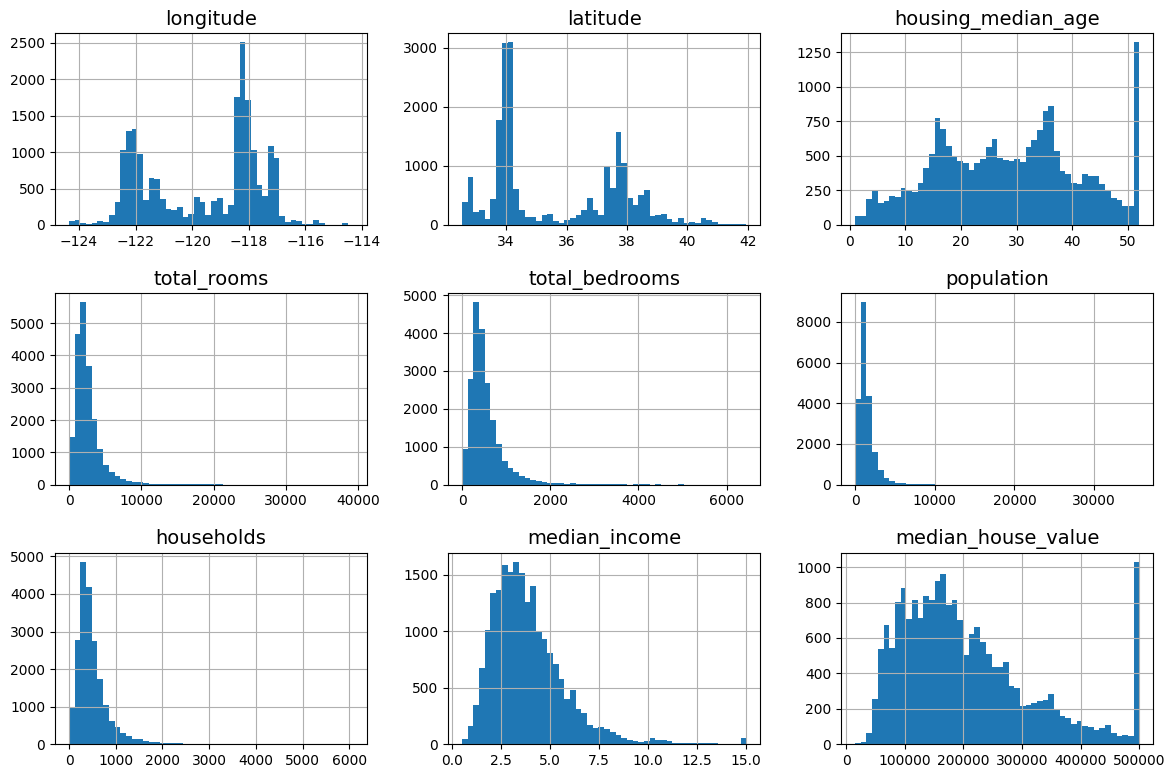

In [9]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

## Create a test set

In [10]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
np.random.seed(42)

Here we hash all values belonging to the test set to ensure that, as the data gets refreshed, no vector previously in the training set gets leaked into the test set. This will keep the model from becoming biased and reduce the chance of overfitting as the data gets refreshed.

In [14]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index() #Adds and index column to the housing dataframe.
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

Rather than creating an index, we can use latitude and longitude as identifiers. This is because they are very stable (only susceptible to continental drift). The problem with using the aforementioned split is that you have to append every single row to the end and ensure no rows are removed.

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [17]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set["total_bedrooms"].isnull().sum()

44

In [19]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=["low", "low-medium", "medium", "medium-high", "high"])

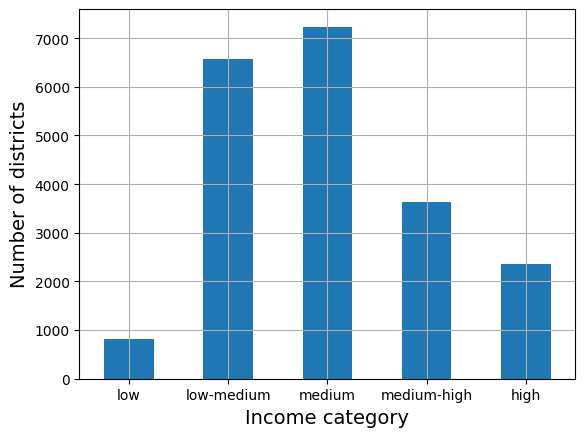

In [20]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
"""
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc(train_index)
    strat_test_set_n = housing.iloc(test_index)
    strat_splits.append([strat_train_set_n, strat_test_set_n])
"""

'\nsplitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)\nstrat_splits = []\nfor train_index, test_index in splitter.split(housing, housing["income_cat"]):\n    strat_train_set_n = housing.iloc(train_index)\n    strat_test_set_n = housing.iloc(test_index)\n    strat_splits.append([strat_train_set_n, strat_test_set_n])\n'

In [22]:
#strat_train_set, strat_test_set = strat_splits[0]

Much easier and shorter way using train_test_split, here we just use a stratify parameter over the relevant column we created earlier.

In [23]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
medium         0.350533
low-medium     0.318798
medium-high    0.176357
high           0.114341
low            0.039971
Name: count, dtype: float64

In [25]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
low,3.98,4.00,4.24,0.36,6.45
low-medium,31.88,31.88,30.74,-0.02,-3.59
medium,35.06,35.05,34.52,-0.01,-1.53
medium-high,17.63,17.64,18.41,0.03,4.42
high,11.44,11.43,12.09,-0.08,5.63


In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize Data

In [27]:
housing = strat_train_set.copy()

Simple graph that uses the latitude and longitude parameters to create a graph of california housing districts. The reason the second example is better is due to the introduction of the alpha paramter, making each data point transparent which in turn makes the density of the combined districts clearer.

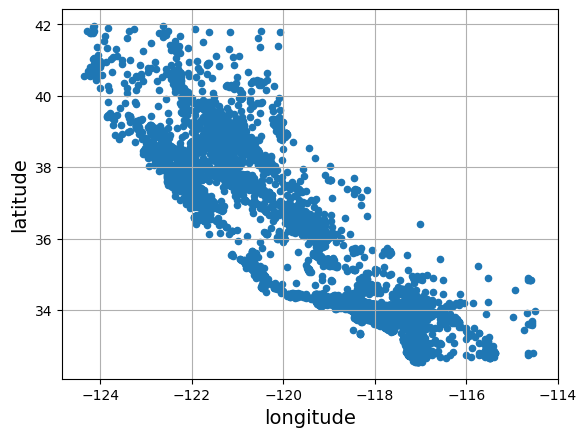

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

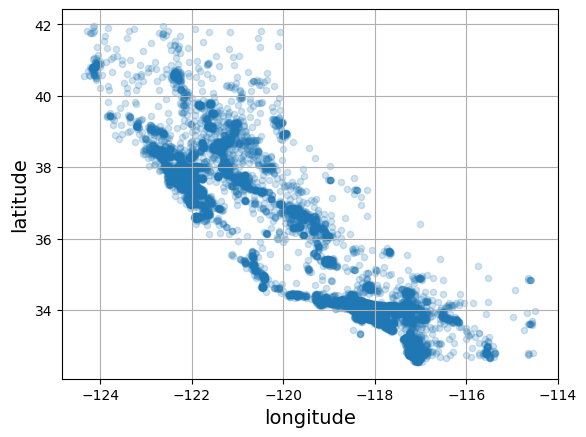

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

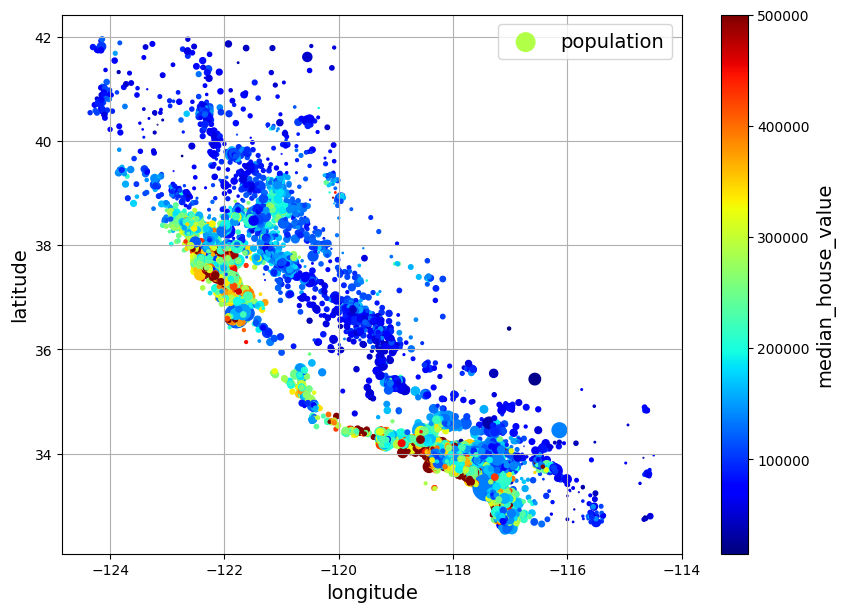

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

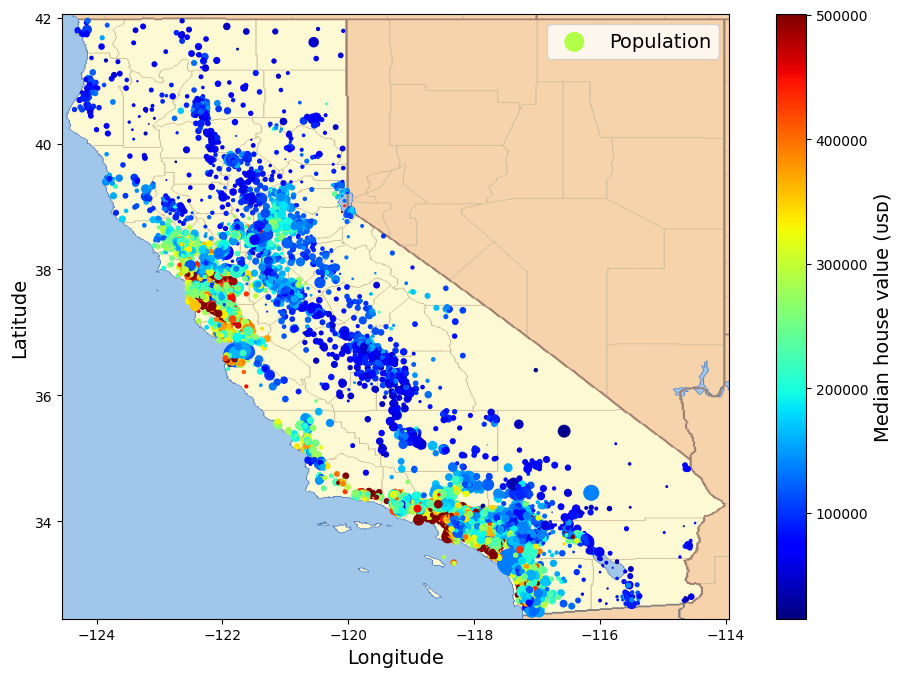

In [31]:
# extra code – this cell generates the first figure in the chapter
# Simply overlaying the last plot onto an image of the state of california.
# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

In [32]:
corr_matrix = housing.corr(numeric_only=True)

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686907
total_rooms           0.131320
housing_median_age    0.109677
households            0.062113
total_bedrooms        0.046629
population           -0.026792
longitude            -0.044139
latitude             -0.143810
Name: median_house_value, dtype: float64

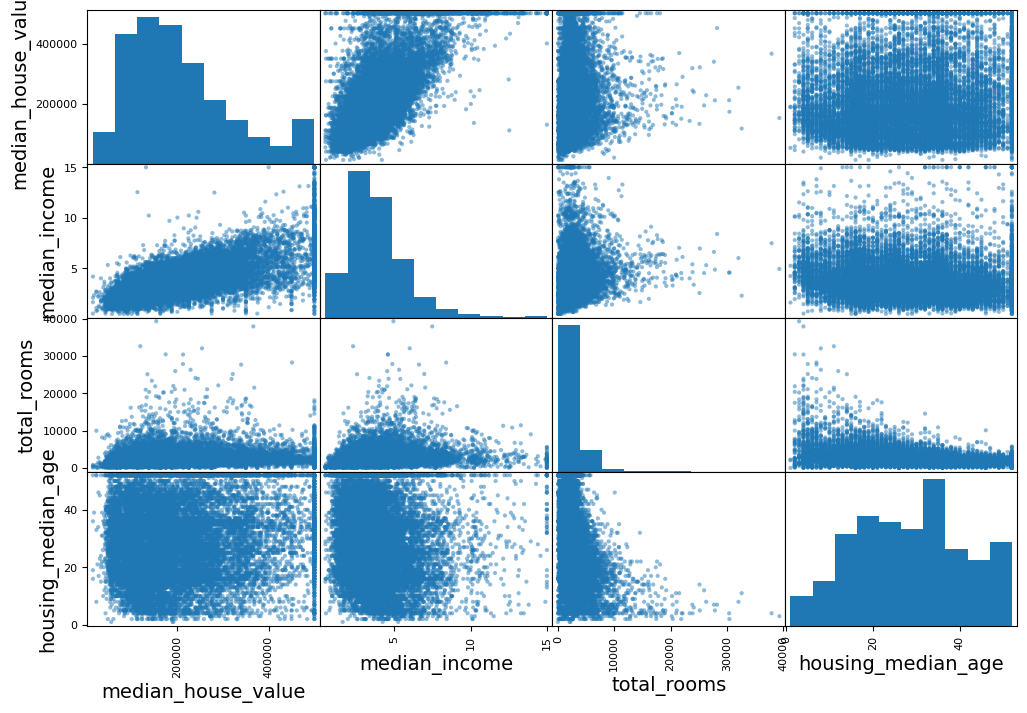

In [34]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

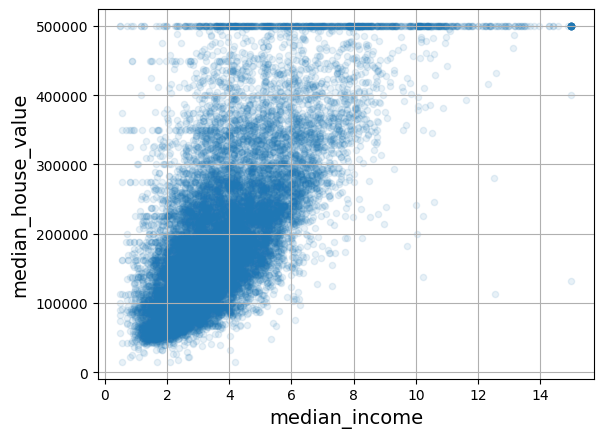

In [35]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

### Experiment w/ attribute combos

Here we create a few different columns using the information we already have in the dataset and find the correlation coefficients for those in relation to the median house value. The bedrooms_ratio attribute seems to stick out.

In [36]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"] 

In [37]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686907
rooms_per_house       0.159235
total_rooms           0.131320
housing_median_age    0.109677
households            0.062113
total_bedrooms        0.046629
people_per_house     -0.026640
population           -0.026792
longitude            -0.044139
latitude             -0.143810
bedrooms_ratio       -0.253449
Name: median_house_value, dtype: float64

# Prepare data for machine learning algorithms

In [38]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Cleaning our data

The book provides the three following ways to handle NaN values

In [39]:
# just getting a peek at the data to see the problem rows
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11644,-117.66,33.51,18.0,2626.0,NaN,1302.0,522.0,4.0167,<1H OCEAN
11220,-117.31,34.25,29.0,4610.0,NaN,1569.0,592.0,2.7663,INLAND
9531,-119.44,36.58,37.0,1054.0,NaN,879.0,257.0,2.5234,INLAND
10490,-121.95,37.31,27.0,4140.0,NaN,2135.0,893.0,3.6292,<1H OCEAN
15857,-118.18,34.19,48.0,1371.0,NaN,528.0,155.0,15.0001,<1H OCEAN


In the next three code boxes we are specifically dropping NaN values from the total_bedrooms column. In the last code box we simply found the indexes of any column with a NaN value and proceeded to show the first five relevant rows.

In [40]:
housing_option1 = housing.copy()
housing_option1.dropna(subset="total_bedrooms", inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [41]:
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
11644,-117.66,33.51,18.0,2626.0,1302.0,522.0,4.0167,<1H OCEAN
11220,-117.31,34.25,29.0,4610.0,1569.0,592.0,2.7663,INLAND
9531,-119.44,36.58,37.0,1054.0,879.0,257.0,2.5234,INLAND
10490,-121.95,37.31,27.0,4140.0,2135.0,893.0,3.6292,<1H OCEAN
15857,-118.18,34.19,48.0,1371.0,528.0,155.0,15.0001,<1H OCEAN


Below will not work after pandas 3.0

In [42]:
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)
housing_option3.loc[null_rows_idx].head()

C:\Users\USER\AppData\Local\Temp\ipykernel_20916\1614985501.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11644,-117.66,33.51,18.0,2626.0,434.0,1302.0,522.0,4.0167,<1H OCEAN
11220,-117.31,34.25,29.0,4610.0,434.0,1569.0,592.0,2.7663,INLAND
9531,-119.44,36.58,37.0,1054.0,434.0,879.0,257.0,2.5234,INLAND
10490,-121.95,37.31,27.0,4140.0,434.0,2135.0,893.0,3.6292,<1H OCEAN
15857,-118.18,34.19,48.0,1371.0,434.0,528.0,155.0,15.0001,<1H OCEAN


The purpose of the imputer object is to set missing values in the data to a specific value, in this case we will be using the median of the specified feature. This is a similar strategy to the antiquated third option above, but is less destructive to the dataset in that we don't end up losing any rows.

In [43]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Below we make a subset of the housing dataset that only includes features with the number data type. In order to fit the imputer using the median strategy we must have a dataset with only numbers.

In [44]:
housing_num = housing.select_dtypes(include=[np.number])

In [45]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

Here we print the imputer stats which show the median for every continuous feature, and verify that the values are correct in the following code box.

In [46]:
imputer.statistics_

array([-118.48  ,   34.25  ,   29.    , 2127.    ,  434.    , 1166.    ,
        409.    ,    3.5338])

In [47]:
housing_num.median().values

array([-118.48  ,   34.25  ,   29.    , 2127.    ,  434.    , 1166.    ,
        409.    ,    3.5338])

In [48]:
X = imputer.transform(housing_num)
print(X)

[[-121.83     37.02     22.     ...  760.      322.        2.9559]
 [-122.27     37.89     52.     ...  723.      272.        5.3989]
 [-117.7      33.64     15.     ... 2380.      773.        8.1926]
 ...
 [-118.18     34.05     41.     ...  817.      176.        3.75  ]
 [-118.04     33.99     47.     ... 1262.      509.        3.6475]
 [-116.24     33.73     14.     ... 1530.      505.        3.0682]]


In [49]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [50]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [51]:
housing_tr.loc[null_rows_idx].head()  # not shown in the book

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
11644,-117.66,33.51,18.0,2626.0,434.0,1302.0,522.0,4.0167
11220,-117.31,34.25,29.0,4610.0,434.0,1569.0,592.0,2.7663
9531,-119.44,36.58,37.0,1054.0,434.0,879.0,257.0,2.5234
10490,-121.95,37.31,27.0,4140.0,434.0,2135.0,893.0,3.6292
15857,-118.18,34.19,48.0,1371.0,434.0,528.0,155.0,15.0001


Dropping outliers

In [52]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [53]:
outlier_pred

array([1, 1, 1, ..., 1, 1, 1])

In [54]:
#run to drop outliers
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

### Handling text and categorical attributes

Here we preprocess the attribute ocean_proximity

In [55]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
2231,<1H OCEAN
3397,NEAR BAY
9533,<1H OCEAN
3482,INLAND
16621,<1H OCEAN
17826,INLAND
14680,<1H OCEAN
2391,NEAR BAY


The problem with using the Ordinal encoder is that ML algorithms will assume similarity of categories with similar numbers even if none exists. For income categories (low, medium, high) this ordinal encoder would be fine, however for ocean_proximity the following one-hot encoder would be better suited.

In [56]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [57]:
housing_cat_encoded[:8]

array([[0.],
       [3.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [3.]])

In [58]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [88]:
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [61]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

One hot encoder can also change the default from a sparse array to a dense array here.

In [62]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [64]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [65]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [66]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [67]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [68]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

the get_feature_names_out() function can be used for specifying columns in dataframes.

In [69]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [70]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [71]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


### Feature Scaling

The following features are used to scale training data. The reason for doing so is that machine learning models will perform better when the training data is scaled to something resembling a gaussian distribution as opposed to having a strong skew. Depending on the skew and the presence of outliers certain scaling techniques will perform better than others. Here the standard scaler works better than the MinMax scaler when there are outliers in the data. Another strategy for data with a heavy skew is to use logarithms to normalize as seen in the first figure below.

In [72]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [75]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

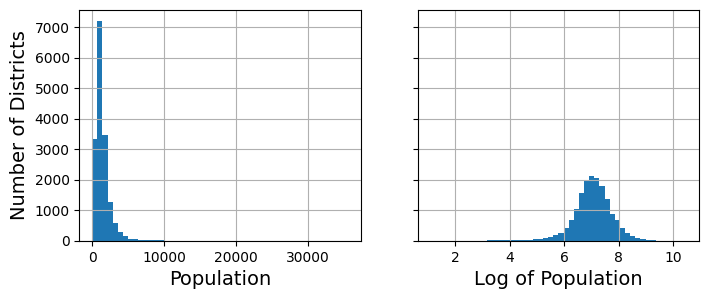

In [76]:
#extra code
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of Population")
axs[0].set_ylabel("Number of Districts")
#save_fig("long_tail_plot")
plt.show()

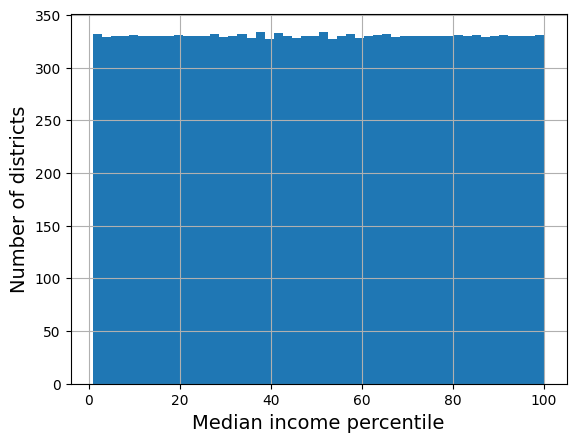

In [77]:

# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

In [79]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

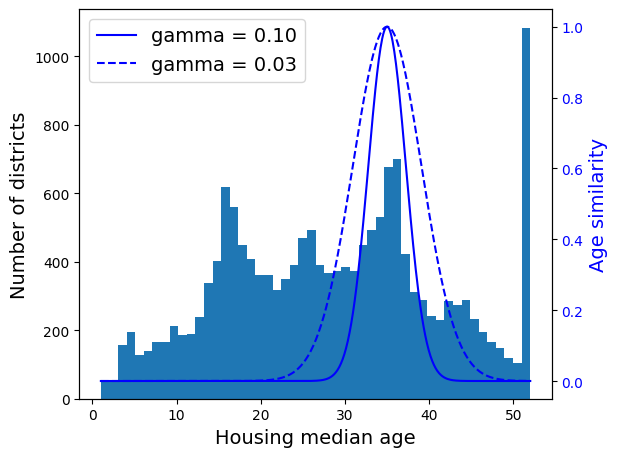

In [80]:
# extra code – this cell generates Figure 2–18

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [81]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [82]:
predictions

array([[168673.08640804],
       [270244.25721519],
       [386396.27517831],
       [126851.37510435],
       [226376.98651579]])

Much easier way to do the prior cell

In [84]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [85]:
predictions

array([168673.08640804, 270244.25721519, 386396.27517831, 126851.37510435,
       226376.98651579])

### Custom Transformers

Custom transformer that simply finds the logarithm of the inputted feature. The inverse parameter is optional, lets you specify an inverse transformation if needed, would be useful in situations like the prior cell where we use a TransformedTargetRegressor that utilizes an inverse transform when the predict function is called.

In [89]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

Transformer that computes the same rbf function as earlier.

In [90]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

Another example of a custom rbf kernel that computes the similarities between not the housing median age, but the latitude and longitude of the data. The rows in the sf_simil array would correspond to a scaled representation of each district's geographic distance from san fransisco.

In [91]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [92]:
sf_simil

array([[0.91335796],
       [0.99672059],
       [0.01968005],
       ...,
       [0.04171986],
       [0.03535778],
       [0.00432643]])

Transformer that computes the ratio of the input features 0 and 1

In [94]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

If you would like your transformer to be trainable then you must write a custom class.

Here we create a clone of the standard scaler. When creating these custom classes for transformers you must include a fit function, a transform function, and a fit_transform function. The addition of the TransformerMixin base class takes care of the fit_transform function.

Including the BaseEstimator base class gives you the get_params() and set_params() methods which are useful for automatic hyperparameter tuning which we will cover later.

It is important to note that this implementation is not complete, all estimators must have feature_names_in_ defined in the fit method as well as a get_feature_names_out() function in the transformer. an inverse_transform() method is also required if the transformer can be reversed. 

In [96]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = check_array(X) #Checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_n_ = X.shape(1) #every estimator stores this in the fit function
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_n_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Here we create a custom transformer that uses a KMeans clusterer in the fit method to identify clusters in the training data, then uses an rbf_kernel in the transform method to find how similar each sample is to each cluster center.

In [98]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight) #Sample weight determines the relative weights of each sample.
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

Here we instantiate our prior custom transformer using 10 as our n_clusters hyperparam. We track the similarities of every district's x and y coordinates to the ten clusters the fit method returned and use the median house price to determine the sample weight. 

In [99]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

In [100]:
similarities[:3].round(2)

array([[0.  , 0.71, 0.  , 0.09, 0.01, 0.14, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.86, 0.  , 0.21, 0.  , 0.83, 0.  , 0.  , 0.  , 0.  ],
       [0.96, 0.  , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.74]])

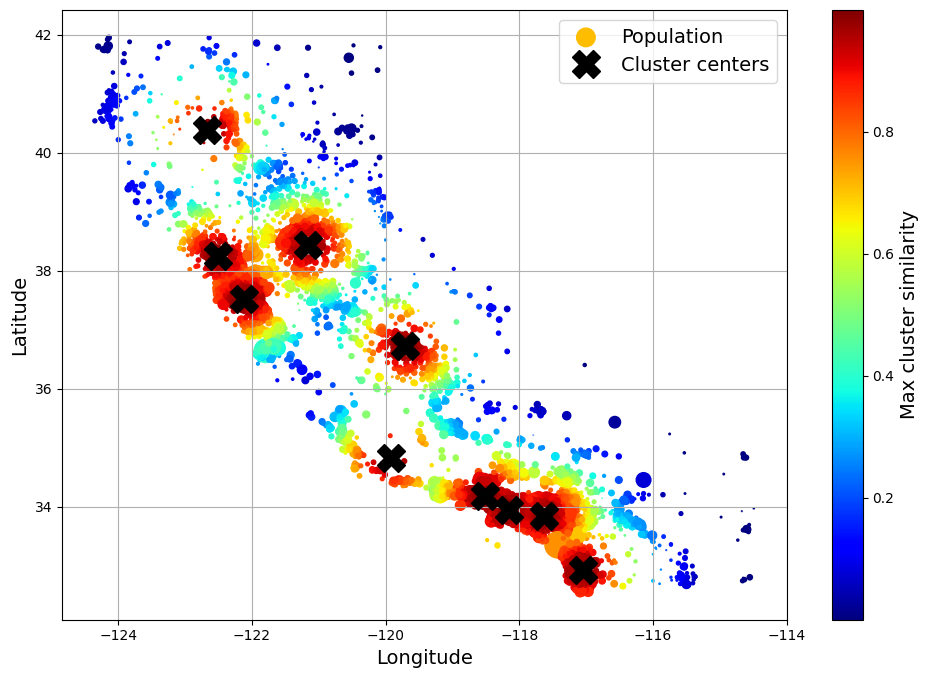

In [102]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

### Transformation Pipelines